In [1]:
import math
import pypoman
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from scipy.stats import bernoulli, uniform, chi2
import numpy as np
from scipy.stats.mstats import gmean
from numpy.testing import assert_allclose
from iteround import saferound
from utils import Bets, Allocations, Weights, mart, lower_confidence_bound, wright_lower_bound,\
    intersection_mart, plot_marts_eta, construct_eta_grid, union_intersection_mart, selector
np.random.seed(123456789)

## Wright's method vs UI-NNSM for non-random populations

In the cell below, we construct a range of $K=2$ strata populations. Each stratum is just a point-mass, so the samples are not in fact random. We alter the global alternative (`alt_grid`), the spread between the stratum values (`delta_grid`), the sample size from each stratum (`n_grid`), and the type of bet ($\lambda_i$) used (`bets_dict`). We see whether a test based on wright's method, a UI-NNSM using product combining, or a UI-NNSM using Fisher combining rejects the global null of $\eta_0 = 0.5$ at level $\alpha = 0.05$. The tests reject after all $n_0 + n_1$ samples are consumed (we do not take running maxes over $t$ or deal with stratum allocation $T_k(t)$). There is no need to replicate the experiments because there is no randomness involved anywhere.  

In [ ]:
alt_grid = [0.55, 0.6, 0.7]
delta_grid = [0, 0.1, 0.5]
alpha = 0.05
eta_0 = 0.5
bets_grid = ["fixed", "agrapa", "smooth_predictable"]
bets_dict = {"fixed":Bets.fixed, "agrapa":Bets.agrapa, "smooth_predictable":Bets.smooth_predictable}
K = 2
N = [30, 30]
results = []
#TODO: add UI-NNSMs with different combining functions 
for alt, delta, bet in itertools.product(alt_grid, delta_grid, bets_grid):
    means = [alt - 0.5*delta, alt + 0.5*delta]
    calX = [[0, means[0]],[0, means[1]]]
    samples = [np.ones(N[0]) * means[0], np.ones(N[1]) * means[1]]
    eta_grid, calC, ub_calC = construct_eta_grid(eta_0, calX, N) 
    wlb = wright_lower_bound(
        x = samples, 
        N = N, 
        lam_func = bets_dict[bet], 
        allocation_func = Allocations.round_robin,
        alpha = alpha, 
        breaks = 1000)
    uinnsm_product = union_intersection_mart(
        x = samples, 
        N = N,
        etas = eta_grid, 
        lam_func = bets_dict[bet], 
        allocation_func = Allocations.round_robin,
        combine = "product", 
        log = False)[0]
    uinnsm_fisher = union_intersection_mart(
        x = samples, 
        N = N,
        etas = eta_grid, 
        lam_func = bets_dict[bet], 
        allocation_func = Allocations.round_robin,
        combine = "fisher", 
        log = False)[0]
    wlb_stop = np.where(any(wlb > eta_0), np.argmax(wlb > eta_0), np.sum(N))
    uinnsm_product_stop = np.where(any(uinnsm_product > 1/alpha), np.argmax(uinnsm_product > 1/alpha), np.sum(N))
    uinnsm_fisher_stop = np.where(any(uinnsm_fisher < alpha), np.argmax(uinnsm_fisher < alpha), np.sum(N))
    data_dict = {
        "alt":alt, 
        "delta":delta, 
        "bet":str(bet), 
        "wright" : wlb_stop, 
        "uinnsm_product" : uinnsm_product_stop,
        "uinnsm_fisher" : uinnsm_fisher_stop}
    results.append(data_dict)
results = pd.DataFrame(results)

In [ ]:
#all results
print(results.to_string())

In [ ]:
N = [50, 50]
x = [0.5 * np.ones(50), 0.6 * np.ones(50)]
plot_marts_eta(x = x,
               N = N, 
               lam_func = Bets.smooth_predictable, 
               allocation_func = Allocations.proportional_round_robin,
               combine = "product",
               res = 2e-2)

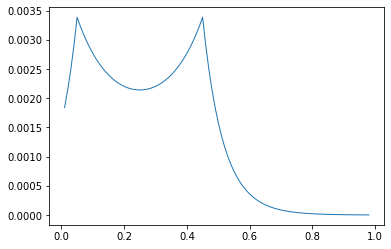

In [21]:
#fisher combining isn't even unimodal... i.e. it seems like it will be difficult to scale
plot_marts_eta(
    x = samples, 
    N = N, 
    lam_func = Bets.lam_fixed, 
    combine = "fisher", 
    theta_func = Weights.theta_fixed, 
    log = False)